## Assignment 6

In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
from typing import Mapping, Callable

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from numpy import linalg

sns.set(rc={'figure.figsize':(12, 8)})
sns.set()

np.random.seed(11148705)

### Parameters

In [4]:
sigmas = {
    'alpha': 1,
    'epsilon': 1,
    'xi': 1
}

coeff = {
    'rho': 0.5,
    'pi': 1,
    'theta': 0,
    'beta': 1
}

N = 100
T = 5

### Data generation

In [5]:
def stationary_x(alpha: np.array, N: int, rho:float, pi: float, theta:float, **_)->np.array: 
    
    den = 1-rho
    den_squared = np.sqrt(den * (1+rho))
    v = np.random.normal(0, 1, (N,1))
    xi = np.random.normal(0, 1, (N,1))
    
    alpha_init = (pi*alpha[:,0]) / den
    disturbance_init = (theta*v + xi) / den_squared
    
    
    return alpha_init + disturbance_init[:, 0]

In [6]:
def generate_data(
    T: int,
    N: int,
    sigmas: Mapping[str, float],
    coeff: Mapping[str, float]
) -> np.array:
    
    alpha_unstacked = np.random.normal(0, sigmas['alpha'], (N, 1))
    alpha = alpha_unstacked @ np.ones((1, T))
    
    epsilon = np.random.normal(0, sigmas['epsilon'], (N, T))
    
    init_x = stationary_x(alpha, N, **coeff)
    
    X = np.zeros((N, T))
    X[:, 0] = init_x
    
    xi = np.random.normal(0, sigmas['xi'], (N, T))
        
    for t in range(1, T):
        X[:, t] = coeff['rho'] * X[:, t-1] + coeff['pi'] * alpha[:, 0] + coeff['theta'] * epsilon[:, t-1]
        
    X = X + xi

    y = coeff['beta'] * X + alpha + epsilon
    
    
    return y, X, alpha

In [7]:
y, X, alpha = generate_data(T, N, sigmas, coeff)

### Utils

In [8]:
Diff_matrix = lambda T: -1*np.eye(T-1, T) + np.eye(T-1, T, k=1)
Q_matrix = lambda T: np.identity(T) - np.ones((T, T))/T

In [9]:
projection = lambda X: X @ linalg.inv(X.T @ X) @ X.T

def residual_matrix(X):
    
    P = projection(X)
    return np.identity(P.shape[0]) - P

## Standard estimators

In [10]:
def beta_ols(X, y):
    inv = linalg.inv(X.T@X)
    
    return inv@(X.T@y)

In [11]:
def standard_error(X, y):
    e = residual_matrix(X)@y
    sigma_hat = (e.T@e)/X.shape[0]
    
    return sigma_hat

In [12]:
def pooled(y, X, *rest):
    intercept = np.kron(np.identity(N), np.ones((T, 1)))
    W = np.concatenate((intercept, X.reshape(-1, 1)), axis=1)

    theta_hat = beta_ols(W, y.reshape(-1, 1))
    std_error = standard_error(W, y.reshape(-1, 1))
    
    return theta_hat[-1, 0], std_error[-1, 0]

In [13]:
def fixed_effects(y, X, *rest):
    N, T = X.shape
    
    Q = Q_matrix(T)
    X_dem = (X @ Q).reshape(-1, 1)
    y_dem = (y @ Q).reshape(-1, 1)
    beta_hat = beta_ols(X_dem, y_dem)
    
    std_error = standard_error(X_dem, y_dem)
    
    return beta_hat[-1, 0], std_error

In [14]:
def first_diff(y, X, *rest):
    N, T = X.shape
    
    D = Diff_matrix(T)
    X_diff = (X @ D.T).reshape(-1, 1)
    y_diff = (y @ D.T).reshape(-1, 1)
    
    beta_hat = beta_ols(X_diff, y_diff) 
    
    std_error = standard_error(X_diff, y_diff) 
    
    return beta_hat[-1, 0], std_error

### Monte carlo

In [46]:
def monte_carlo_estimation(
    T, N,
    sigmas=sigmas,
    coeff=coeff,
    estimators: Mapping[str, Callable]={},
    iterations: int = 1000,
    verbose = 0,
):
    results = dict(
            (method, {'beta': np.zeros(iterations), 'sigma': np.zeros(iterations)}) for method in estimators.keys()
        )
    
    for i in range(iterations):
        if verbose > 0:
            print(f'Iteration: {i+1}/{iterations}', end='\r')
            
        y, X, alpha = generate_data(T, N, sigmas, coeff)
        
        for method, estimate_fn in estimators.items():
            beta, std_error = estimate_fn(y, X, alpha)
            results[method]['beta'][i] = beta
            results[method]['sigma'][i] = std_error
            
        
    for method, stat in results.items():
        stat['std'] = np.std(stat['beta'])
        stat['mean'] = np.mean(stat['beta'])
        
        stat['average_bias'] = np.mean(stat['beta'] - coeff['beta'])
    
    return results
        

In [44]:
models = {'first_diff': first_diff, 'fixed_effects': fixed_effects}
iterations = 1_000

r = monte_carlo_estimation(T, N, sigmas, coeff, models, iterations, verbose=0)

In [17]:
data = {}
for method, stat in r.items():
    d = {f'{method}_beta': stat['beta'], f'{method}_upper':  stat['beta'] + stat['sigma'], f'{method}_lower':  stat['beta'] - stat['sigma']}
    data = {**data, **d}

df = pd.DataFrame(data)

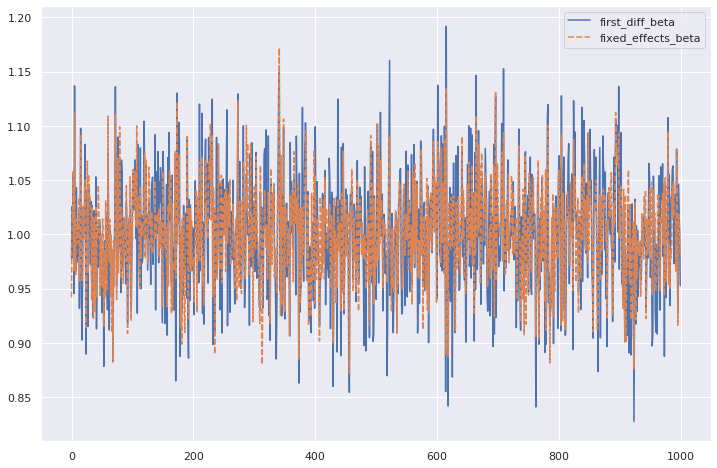

In [18]:
sns.lineplot(data=df[[col for col in df.columns if 'beta' in col]])
plt.show()

### Summary results

In [19]:
avg_bias = {method: [] for method in models.keys()}
avg_beta = {method: [] for method in models.keys()}
avg_std = {method: [] for method in models.keys()}

iterations_space = np.logspace(2, 4, num=10).astype(int)

print('Number of iterations, ', iterations_space)

Number of iterations,  [  100   166   278   464   774  1291  2154  3593  5994 10000]


In [20]:
verbosity = 0
for iterations in iterations_space:
    if verbosity > 0:
        print('\n')
    r = monte_carlo_estimation(T, N, sigmas, coeff, models, iterations, verbose=verbosity)
    for method, stat in r.items():
        avg_bias[method].append(stat['average_bias'])
        avg_beta[method].append(stat['mean'])
        avg_std[method].append(stat['std'])

In [21]:
biases = pd.DataFrame(avg_bias, index=iterations_space)
means = pd.DataFrame(avg_beta)

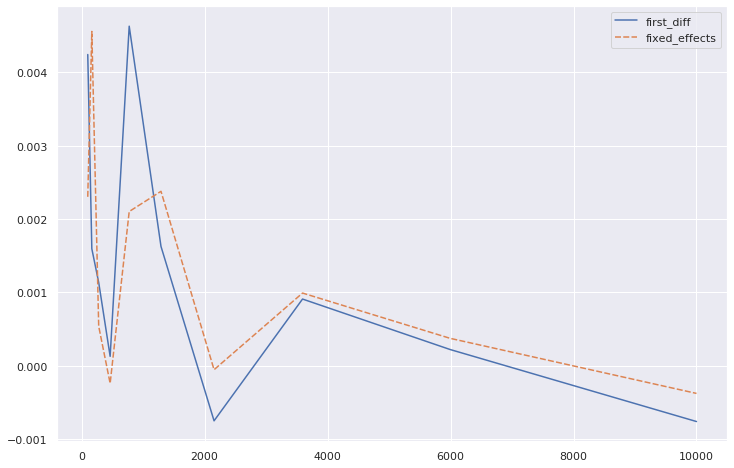

In [22]:
sns.lineplot(data=biases)
plt.show()

### Robustness over $\pi$

In [23]:
iterations = 1000
possible_pis = np.linspace(0.1, 30)

In [24]:
results = {method: [] for method in models.keys()}
for pi in possible_pis:
    r = monte_carlo_estimation(T, N, sigmas=sigmas, estimators=models, iterations=iterations, coeff={**coeff, 'pi': pi})
    
    for method, stats in r.items():
        results[method].append(stats['mean'])

results = pd.DataFrame(results, index=possible_pis)

In [25]:
def plot_prob(results, x = ''):
    print('Distribution')
    sns.kdeplot(results['first_diff'])
    sns.kdeplot(results['fixed_effects'])
    plt.legend()
    plt.show()
    
    
    print('Value of Beta over ', x)
    ax = sns.lineplot(data=results)
    ax.set(ylabel='Beta', xlabel=x)
    plt.show()

Distribution


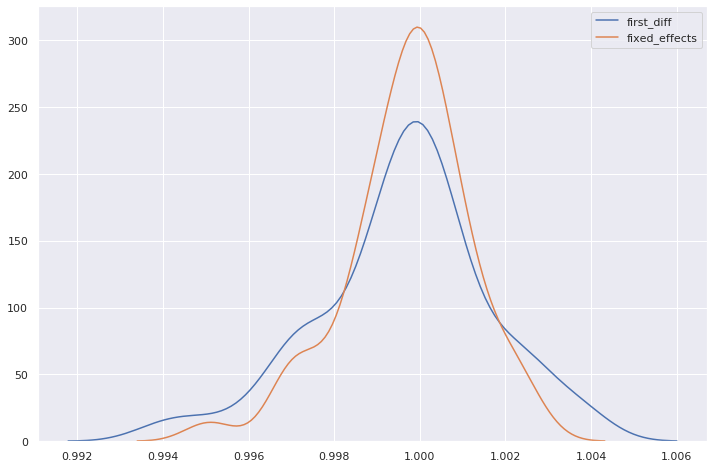

Value of Beta over  pi


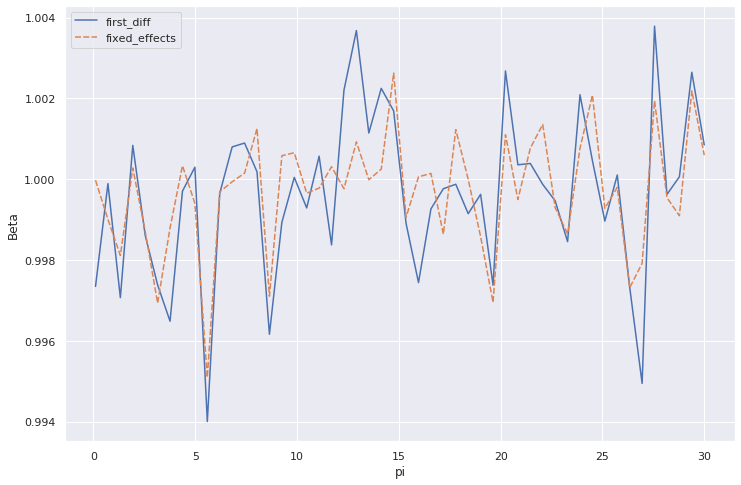

In [26]:
plot_prob(results, x='pi')

### Robustness over $\theta$

In [27]:
iterations = 1000
possible_thetas = np.linspace(0, 1)

In [28]:
results = {method: [] for method in models.keys()}
for theta in possible_thetas:
    r = monte_carlo_estimation(T, N, sigmas=sigmas, estimators=models, iterations=iterations, coeff={**coeff, 'theta': theta})
    
    for method, stats in r.items():
        results[method].append(stats['mean'])

results = pd.DataFrame(results, index=possible_thetas)

Distribution


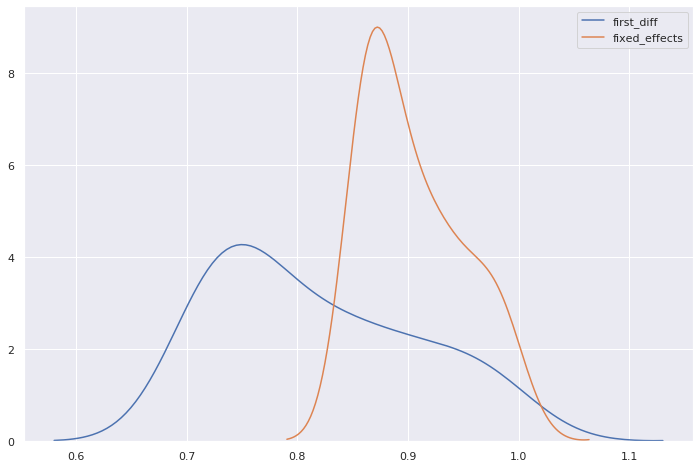

Value of Beta over  theta


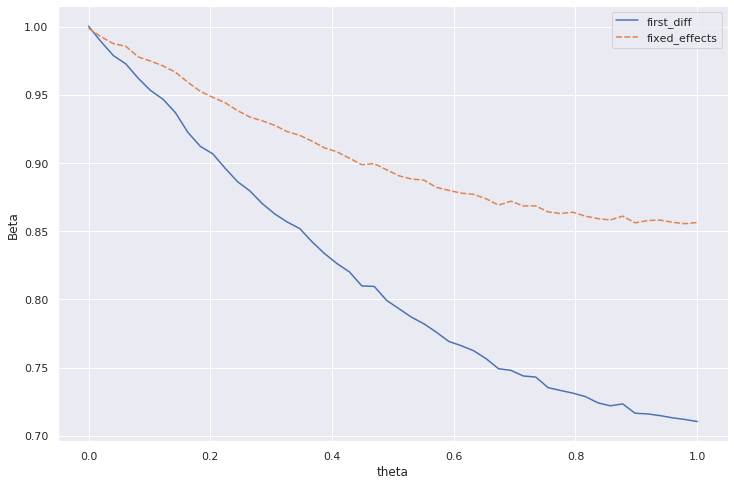

In [29]:
plot_prob(results, x='theta')

## IV/GMM estimators

In [30]:
%notify

<IPython.core.display.Javascript object>

In [31]:
import scipy.optimize as opt

In [47]:
Z_standard = X[:, :-1]

In [48]:
Z_diag = np.array([np.diag(Z_standard[i]) for i in range(Z_standard.shape[0])])

In [49]:
instruments = [Z_standard, Z_diag]

In [88]:
def gmm(Z):
    def estimate(y, X, *rest):
        N, T = X.shape
        D = Diff_matrix(T)

        y_diff = (y @ D.T)
        X_diff = (X @ D.T)

        w_i = np.array([Z[i].T @ D @ D.T @ Z[i] for i in range(N)])

        inv_W = np.sum(w_i, axis = 0)

        if isinstance(inv_W, np.float):
            inv_W = inv_W*np.ones((1,1))

        W_n = linalg.inv(inv_W)



        def criterion(beta):
            Q = 0
            for i in range(N):

                error = np.array(Z[i] @ (y_diff[i] - beta*X_diff[i].T), ndmin=1)
                Q += error.T@W_n@error

            return Q 


        results = opt.minimize(criterion, 0, method='L-BFGS-B')
        beta = results.x
            
        return np.asscalar(beta), None
    
    return estimate

In [90]:
models = {'standard': gmm(Z_standard), 'diagonal': gmm(Z_diag)}
iterations = 1_000

r = monte_carlo_estimation(T, N, sigmas=sigmas, estimators=models, iterations=iterations, coeff=coeff, verbose=1)

Number of iterations,  [ 100  131  162  193  224  255  286  317  348  379  410  441  472  503
  534  565  596  627  658  689  720  751  782  813  844  875  906  937
  968 1000]


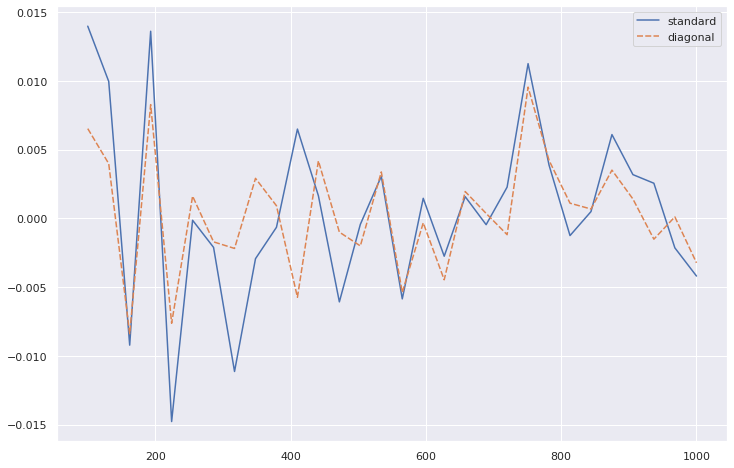

In [98]:
avg_bias = {method: [] for method in models.keys()}
n_iter = 30
iterations_space = np.linspace(100, 1_000, num=n_iter).astype(int)

print('Number of iterations, ', iterations_space)

verbosity = 1
for j, iterations in enumerate(iterations_space):
    r = monte_carlo_estimation(T, N, sigmas, coeff, models, iterations, verbose=0)
    for method, stat in r.items():
        avg_bias[method].append(stat['average_bias'])
        
    if verbosity > 0:
        print(f'Progress {j+1}/{n_iter}', end='\r')
        
biases = pd.DataFrame(avg_bias, index=iterations_space)
sns.lineplot(data=biases)
plt.show()

In [99]:
%notify

<IPython.core.display.Javascript object>